### Classification of Kaggle Coins Dataset with Siamese Network (using data augmentation)





In [1]:
# load data from google drive
!unzip /content/drive/MyDrive/data_kaggle_coins.zip

Streaming output truncated to the last 5000 lines.
  inflating: coins/data/train/172/017__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/020__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/021__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/022__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/023__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/024__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/025__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/026__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/027__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/028__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/029__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/030__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/031__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/033__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/035__50 Ore_sweden.jpg  
  inflating: coins/data/train/172/036__50 Ore_sweden.jpg  
  inf

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

import keras
import cv2
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt

from keras import backend as K


from sklearn.decomposition import PCA


from keras.applications import resnet50


import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot


import time

import pickle




In [3]:
batch_size = 32
img_height = 256
img_width =  256

In [4]:
# data generators

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255
            )

train_generator = datagen.flow_from_directory(
                    'coins/data/train',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    shuffle=True,
                    seed=123
                    )


valid_generator = datagen.flow_from_directory(
                    'coins/data/validation',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    shuffle=True,
                    seed=123
                    )


test_generator = datagen.flow_from_directory(
                    'coins/data/test',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    shuffle=True,
                    seed=123
                    )
        


Found 6413 images belonging to 211 classes.
Found 844 images belonging to 211 classes.
Found 844 images belonging to 211 classes.


In [5]:
X_train=[]
y_train=[]

train_generator.reset()

for i in range(train_generator.__len__()):
   a,b=train_generator.next()
   X_train.extend(a)
   y_train.extend(b)


X_train=np.array(X_train)
y_train=np.array(y_train)

In [6]:
X_valid=[]
y_valid=[]

valid_generator.reset()

for i in range(valid_generator.__len__()):
   a,b=valid_generator.next()
   X_valid.extend(a)
   y_valid.extend(b)


X_valid=np.array(X_valid)
y_valid=np.array(y_valid)


In [7]:
X_test=[]
y_test=[]

test_generator.reset()

for i in range(test_generator.__len__()):
   a,b=test_generator.next()
   X_test.extend(a)
   y_test.extend(b)


X_test=np.array(X_valid)
y_test=np.array(y_valid)


In [8]:
n_classes = len(y_train[0])

In [9]:
y_train = np.array([y_train[i].tolist().index(1) for i in range(len(y_train))])

y_valid =  np.array([y_valid[i].tolist().index(1) for i in range(len(y_valid))])

y_test =  np.array([y_test[i].tolist().index(1) for i in range(len(y_test))])

In [10]:
# Data augmentation

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=180,
            zoom_range=0.5,
            height_shift_range=0.1,
            width_shift_range=0.1,
           #brightness_range=[0.2,1]
            )

In [11]:
def get_pairs(batch_size,valid=False):

  if valid:

    X = X_valid
    y = y_valid

  else: 

    X = X_train
    y = y_train
   

  n, img_height,img_width, c = X.shape

  pairs=[np.zeros((batch_size, img_height, img_width,c)) for i in range(2)]
  targets=np.zeros((batch_size))

  targets[batch_size//2:] = 1




  for i in range(batch_size):

    
    idx1 = np.random.randint(0,n)

    pairs[0][i,:,:,:] = data_augmentation.flow(X[idx1:idx1+1])[0][0] # apply data augmentation


    idx2 = np.random.randint(0,n)


    if i < batch_size//2 :
    
      while y[idx1] == y[idx2]:

        idx2 = np.random.randint(0,n)
    

    if i >= batch_size//2 :
    
      while y[idx1] != y[idx2]:

        idx2 = np.random.randint(0,n)
  

    pairs[1][i,:,:,:] = data_augmentation.flow(X[idx2:idx2+1])[0][0]  # apply data augmentation



  return pairs, targets

In [12]:
def pairs_generator(batch_size, valid = False):
    while True:
        pairs, targets = get_pairs(batch_size,valid = valid)
        yield (pairs, targets)

In [13]:
# Siamese network

input_left = Layers.Input((img_width,img_height,3))
input_right = Layers.Input((img_width,img_height,3))


resnet_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

base_model = tf.keras.Sequential()
base_model.add(resnet_model)
base_model.add(Layers.GlobalAveragePooling2D())


encoded_left = base_model(input_left)
encoded_right = base_model(input_right)



L1_layer = Layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_left, encoded_right])


prediction = Layers.Dense(1,activation='sigmoid')(L1_distance)

model = tf.keras.models.Model(inputs=[input_left,input_right],outputs=prediction)



model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         23587712    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2048)         0           sequential[0][0]      

In [14]:
model.compile(loss="binary_crossentropy",optimizer = keras.optimizers.Adam(learning_rate=1e-4))

In [13]:
batch_size = 32
steps_per_epoch = X_train.shape[0]//batch_size

validation_steps = X_valid.shape[0]//batch_size

In [14]:
# specify checkpoint file to save weights during training

checkpoint_path = "/content/drive/MyDrive/models/siamese_kaggle/cp.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)


In [17]:
tic=time.time()


trained = model.fit(
            pairs_generator(batch_size),
            steps_per_epoch=steps_per_epoch,
            validation_data = pairs_generator(batch_size,valid=True),
            validation_steps = validation_steps,
            epochs=50,
            callbacks=[cp_callback]
            )


toc=time.time()    
print(str(toc-tic)+ ' s')

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6882
Epoch 00001: val_loss improved from inf to 0.82358, saving model to /content/drive/MyDrive/models/siamese_kaggle/cp.ckpt
200/200 [==============================] - 223s 1s/step - loss: 0.6882 - val_loss: 0.8236
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.6223
Epoch 00002: val_loss improved from 0.82358 to 0.68906, saving model to /content/drive/MyDrive/models/siamese_kaggle/cp.ckpt
200/200 [==============================] - 218s 1s/step - loss: 0.6223 - val_loss: 0.6891
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.5888
Epoch 00003: val_loss improved from 0.68906 to 0.54555, saving model to /content/drive/MyDrive/models/siamese_kaggle/cp.ckpt
200/200 [==============================] - 216s 1s/step - loss: 0.5888 - val_loss: 0.5456
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.5531
Epoch 00004: val_loss improved from 0.54555 to 0.51

In [18]:
# save model
t = time.time()

export_path_keras = "/content/drive/MyDrive/models/siamese_kaggle/{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

/content/drive/MyDrive/models/siamese_kaggle/1606511275.h5


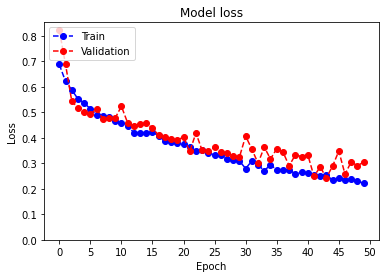

In [20]:
plt.plot(trained.history['loss'],'bo--')
plt.plot(trained.history['val_loss'],'ro--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.xticks(np.arange(0,51,5))
plt.yticks(np.arange(0,0.9,0.1))
plt.show()

In [33]:
# save loss history

f=open("/content/drive/MyDrive/models/siamese_kaggle/trained_loss.obj",'wb')
f1=open("/content/drive/MyDrive/models/siamese_kaggle/trained_val_loss.obj",'wb')


pickle.dump(trained.history['loss'],f)
pickle.dump(trained.history['val_loss'],f1)



In [15]:
# load pickle objects
f=open("/content/drive/MyDrive/models/siamese_kaggle/trained_loss.obj",'rb')
f1=open("/content/drive/MyDrive/models/siamese_kaggle/trained_val_loss.obj",'rb')



loss_array = pickle.load(f)
val_loss_array = pickle.load(f1)

In [16]:
# load the model after google colab crashed

import_path_keras='/content/drive/MyDrive/models/siamese_kaggle/1606511275.h5'

model = tf.keras.models.load_model(import_path_keras)
model.summary()



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         23587712    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2048)         0           sequential[0][0]      

In [20]:
# decrease learning rate, compile model
model.compile(loss="binary_crossentropy",optimizer = keras.optimizers.Adam(learning_rate=1e-5))

In [17]:
# enable garbage collector: RAM full, environment crashes when trying to run accuracy on test set

import gc
gc.enable()

In [18]:
def one_shot_task(X_test1,X_train,y_train):

  pairs=[np.zeros((n_classes, img_height, img_width,3)) for i in range(2)]

  n_samples = len(y_train)

  for i in range(n_classes):

     pairs[0][i,:,:,:] = X_test1


  for i in range(n_classes):

    idx2 = np.random.randint(0,n_samples)

    while y_train[idx2] != i :
      idx2 = np.random.randint(0,n_samples)
    


    pairs[1][i,:,:,:] = X_train[idx2]

  return pairs

In [19]:
def test_accuracy(X_test,y_test,X_train,y_train):

  n_correct = 0
  n_all = len(X_test)


 # pairs = one_shot_task(X_test[0],X_train,y_train)  # generate reference samples from train dataset only once

  for i in range(n_all):

  #  for j in range(n_classes):
   #   pairs[0][j,:,:,:] = X_test[i]
    #print(i)

    pred = np.argmax( model.predict(one_shot_task(X_test[i],X_train,y_train)) )

    if y_test[i] == pred:

      n_correct+=1

    if i!=0 and i%10 == 0: 

      print('step:', i, 'accuracy:', 100 * n_correct/(i+1))
      gc.collect()        #collect garbage to prevent RAM problem

  accuracy = 100.0 * n_correct / n_all
  print('step:', n_all, 'accuracy:',  accuracy)


  return accuracy



In [21]:
#accuracy on test dataset

tic=time.time()

test_accuracy(X_test,y_test,X_train,y_train)


toc=time.time()    
print(str(toc-tic)+ ' s')

step: 10 accuracy: 18.181818181818183
step: 20 accuracy: 14.285714285714286
step: 30 accuracy: 19.35483870967742
step: 40 accuracy: 21.951219512195124
step: 50 accuracy: 23.529411764705884
step: 60 accuracy: 26.229508196721312
step: 70 accuracy: 23.943661971830984
step: 80 accuracy: 22.22222222222222
step: 90 accuracy: 20.87912087912088
step: 100 accuracy: 21.782178217821784
step: 110 accuracy: 24.324324324324323
step: 120 accuracy: 22.31404958677686
step: 130 accuracy: 22.137404580152673
step: 140 accuracy: 21.98581560283688
step: 150 accuracy: 21.192052980132452
step: 160 accuracy: 19.875776397515526
step: 170 accuracy: 20.46783625730994
step: 180 accuracy: 19.337016574585636
step: 190 accuracy: 20.94240837696335
step: 200 accuracy: 20.398009950248756
step: 210 accuracy: 20.379146919431278
step: 220 accuracy: 19.90950226244344
step: 230 accuracy: 19.047619047619047
step: 240 accuracy: 19.91701244813278
step: 250 accuracy: 20.318725099601593
step: 260 accuracy: 19.92337164750958
step:

In [21]:
# keep training


tic=time.time()


trained1 = model.fit(
            pairs_generator(batch_size),
            steps_per_epoch=steps_per_epoch,
            validation_data = pairs_generator(batch_size,valid=True),
            validation_steps = validation_steps,
            epochs=50,
            callbacks=[cp_callback]
            )


toc=time.time()    
print(str(toc-tic)+ ' s')






Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.2097
Epoch 00001: val_loss improved from inf to 0.24520, saving model to /content/drive/MyDrive/models/siamese_kaggle/cp.ckpt
200/200 [==============================] - 221s 1s/step - loss: 0.2097 - val_loss: 0.2452
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.1770
Epoch 00002: val_loss improved from 0.24520 to 0.21869, saving model to /content/drive/MyDrive/models/siamese_kaggle/cp.ckpt
200/200 [==============================] - 221s 1s/step - loss: 0.1770 - val_loss: 0.2187
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.1893
Epoch 00003: val_loss improved from 0.21869 to 0.21450, saving model to /content/drive/MyDrive/models/siamese_kaggle/cp.ckpt
200/200 [==============================] - 222s 1s/step - loss: 0.1893 - val_loss: 0.2145
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.1727
Epoch 00004: val_loss did not improve from 0.21450


In [22]:
# save model
t = time.time()

export_path_keras = "/content/drive/MyDrive/models/siamese_kaggle/{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

/content/drive/MyDrive/models/siamese_kaggle/1606566170.h5


In [23]:
# save loss history

f=open("/content/drive/MyDrive/models/siamese_kaggle/trained1_loss.obj",'wb')
f1=open("/content/drive/MyDrive/models/siamese_kaggle/trained1_val_loss.obj",'wb')


pickle.dump(trained1.history['loss'],f)
pickle.dump(trained1.history['val_loss'],f1)



In [24]:
# load pickle objects
f=open("/content/drive/MyDrive/models/siamese_kaggle/trained1_loss.obj",'rb')
f1=open("/content/drive/MyDrive/models/siamese_kaggle/trained1_val_loss.obj",'rb')



loss_array1 = pickle.load(f)
val_loss_array1 = pickle.load(f1)

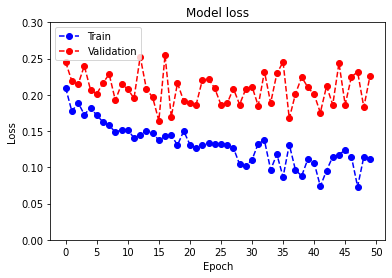

In [25]:
plt.plot(trained1.history['loss'],'bo--')
plt.plot(trained1.history['val_loss'],'ro--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.xticks(np.arange(0,51,5))
plt.yticks(np.arange(0,0.35,0.05))
plt.show()

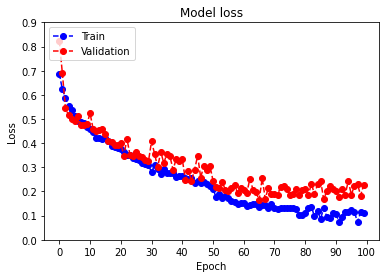

In [31]:
# plot all history

loss_array_all = loss_array + loss_array1
val_loss_array_all = val_loss_array + val_loss_array1

plt.plot(loss_array_all,'bo--')
plt.plot(val_loss_array_all,'ro--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.xticks(np.arange(0,101,10))
plt.yticks(np.arange(0,1,0.1))
plt.show()

In [32]:
#accuracy on test dataset

tic=time.time()

test_accuracy(X_test,y_test,X_train,y_train)


toc=time.time()    
print(str(toc-tic)+ ' s')

step: 10 accuracy: 45.45454545454545
step: 20 accuracy: 33.333333333333336
step: 30 accuracy: 32.25806451612903
step: 40 accuracy: 31.70731707317073
step: 50 accuracy: 33.333333333333336
step: 60 accuracy: 37.704918032786885
step: 70 accuracy: 36.61971830985915
step: 80 accuracy: 38.27160493827161
step: 90 accuracy: 36.26373626373626
step: 100 accuracy: 36.633663366336634
step: 110 accuracy: 37.83783783783784
step: 120 accuracy: 37.1900826446281
step: 130 accuracy: 38.16793893129771
step: 140 accuracy: 37.5886524822695
step: 150 accuracy: 36.42384105960265
step: 160 accuracy: 35.40372670807454
step: 170 accuracy: 35.08771929824562
step: 180 accuracy: 34.806629834254146
step: 190 accuracy: 34.55497382198953
step: 200 accuracy: 34.82587064676617
step: 210 accuracy: 33.175355450236964
step: 220 accuracy: 33.0316742081448
step: 230 accuracy: 33.76623376623377
step: 240 accuracy: 34.024896265560166
step: 250 accuracy: 34.66135458167331
step: 260 accuracy: 34.48275862068966
step: 270 accurac

In [33]:
# decrease learning rate even further, compile model
model.compile(loss="binary_crossentropy",optimizer = keras.optimizers.Adam(learning_rate=1e-6))

In [34]:
# keep training


tic=time.time()


trained2 = model.fit(
            pairs_generator(batch_size),
            steps_per_epoch=steps_per_epoch,
            validation_data = pairs_generator(batch_size,valid=True),
            validation_steps = validation_steps,
            epochs=50,
            callbacks=[cp_callback]
            )


toc=time.time()    
print(str(toc-tic)+ ' s')






Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.1189
Epoch 00001: val_loss did not improve from 0.16433
200/200 [==============================] - 220s 1s/step - loss: 0.1189 - val_loss: 0.1836
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.1084
Epoch 00002: val_loss improved from 0.16433 to 0.15173, saving model to /content/drive/MyDrive/models/siamese_kaggle/cp.ckpt
200/200 [==============================] - 217s 1s/step - loss: 0.1084 - val_loss: 0.1517
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.1115
Epoch 00003: val_loss did not improve from 0.15173
200/200 [==============================] - 216s 1s/step - loss: 0.1115 - val_loss: 0.1684
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.1108
Epoch 00004: val_loss did not improve from 0.15173
200/200 [==============================] - 216s 1s/step - loss: 0.1108 - val_loss: 0.1984
Epoch 5/50
200/200 [==============================] - 

In [35]:
# save model
t = time.time()

export_path_keras = "/content/drive/MyDrive/models/siamese_kaggle/{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

/content/drive/MyDrive/models/siamese_kaggle/1606578188.h5


In [36]:
# save loss history

f=open("/content/drive/MyDrive/models/siamese_kaggle/trained2_loss.obj",'wb')
f1=open("/content/drive/MyDrive/models/siamese_kaggle/trained2_val_loss.obj",'wb')


pickle.dump(trained2.history['loss'],f)
pickle.dump(trained2.history['val_loss'],f1)



In [37]:
# load pickle objects
f=open("/content/drive/MyDrive/models/siamese_kaggle/trained2_loss.obj",'rb')
f1=open("/content/drive/MyDrive/models/siamese_kaggle/trained2_val_loss.obj",'rb')



loss_array2 = pickle.load(f)
val_loss_array2 = pickle.load(f1)

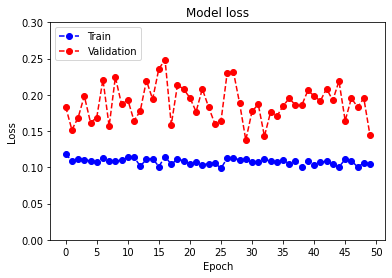

In [38]:
plt.plot(trained2.history['loss'],'bo--')
plt.plot(trained2.history['val_loss'],'ro--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.xticks(np.arange(0,51,5))
plt.yticks(np.arange(0,0.35,0.05))
plt.show()

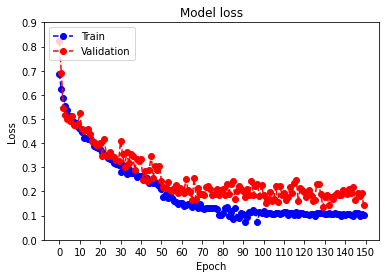

In [39]:
# plot all history

loss_array_all = loss_array + loss_array1 + loss_array2
val_loss_array_all = val_loss_array + val_loss_array1 + val_loss_array2

plt.plot(loss_array_all,'bo--')
plt.plot(val_loss_array_all,'ro--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.xticks(np.arange(0,151,10))
plt.yticks(np.arange(0,1,0.1))
plt.show()

In [40]:
#accuracy on test dataset

tic=time.time()

test_accuracy(X_test,y_test,X_train,y_train)


toc=time.time()    
print(str(toc-tic)+ ' s')

step: 10 accuracy: 45.45454545454545
step: 20 accuracy: 33.333333333333336
step: 30 accuracy: 35.483870967741936
step: 40 accuracy: 36.58536585365854
step: 50 accuracy: 41.1764705882353
step: 60 accuracy: 42.622950819672134
step: 70 accuracy: 43.66197183098591
step: 80 accuracy: 43.20987654320987
step: 90 accuracy: 43.956043956043956
step: 100 accuracy: 44.554455445544555
step: 110 accuracy: 44.14414414414414
step: 120 accuracy: 43.80165289256198
step: 130 accuracy: 41.98473282442748
step: 140 accuracy: 41.843971631205676
step: 150 accuracy: 41.05960264900662
step: 160 accuracy: 39.130434782608695
step: 170 accuracy: 39.76608187134503
step: 180 accuracy: 38.12154696132597
step: 190 accuracy: 39.26701570680628
step: 200 accuracy: 39.30348258706468
step: 210 accuracy: 39.33649289099526
step: 220 accuracy: 38.914027149321264
step: 230 accuracy: 38.52813852813853
step: 240 accuracy: 39.004149377593365
step: 250 accuracy: 38.645418326693225
step: 260 accuracy: 38.31417624521073
step: 270 ac

In [41]:
# increase learning rate, compile model
model.compile(loss="binary_crossentropy",optimizer = keras.optimizers.Adam(learning_rate=1e-5))

In [42]:
# keep training


tic=time.time()


trained3 = model.fit(
            pairs_generator(batch_size),
            steps_per_epoch=steps_per_epoch,
            validation_data = pairs_generator(batch_size,valid=True),
            validation_steps = validation_steps,
            epochs=50,
            callbacks=[cp_callback]
            )


toc=time.time()    
print(str(toc-tic)+ ' s')






Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.1141
Epoch 00001: val_loss did not improve from 0.13758
200/200 [==============================] - 219s 1s/step - loss: 0.1141 - val_loss: 0.1828
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.1024
Epoch 00002: val_loss did not improve from 0.13758
200/200 [==============================] - 217s 1s/step - loss: 0.1024 - val_loss: 0.2121
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.1022
Epoch 00003: val_loss did not improve from 0.13758
200/200 [==============================] - 217s 1s/step - loss: 0.1022 - val_loss: 0.1590
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.1016
Epoch 00004: val_loss did not improve from 0.13758
200/200 [==============================] - 215s 1s/step - loss: 0.1016 - val_loss: 0.1823
Epoch 5/50
200/200 [==============================] - ETA: 0s - loss: 0.0998
Epoch 00005: val_loss did not improve from 0.13758


In [43]:
# save model
t = time.time()

export_path_keras = "/content/drive/MyDrive/models/siamese_kaggle/{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

/content/drive/MyDrive/models/siamese_kaggle/1606589882.h5


In [54]:
# save loss history

f=open("/content/drive/MyDrive/models/siamese_kaggle/trained3_loss.obj",'wb')
f1=open("/content/drive/MyDrive/models/siamese_kaggle/trained3_val_loss.obj",'wb')


pickle.dump(trained3.history['loss'],f)
pickle.dump(trained3.history['val_loss'],f1)



In [55]:
# load pickle objects
f=open("/content/drive/MyDrive/models/siamese_kaggle/trained3_loss.obj",'rb')
f1=open("/content/drive/MyDrive/models/siamese_kaggle/trained3_val_loss.obj",'rb')



loss_array3 = pickle.load(f)
val_loss_array3 = pickle.load(f1)

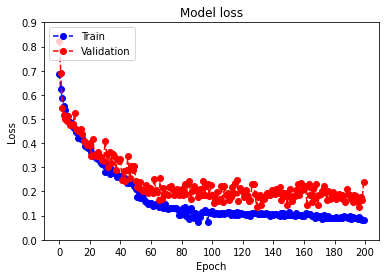

In [56]:
# plot all history

loss_array_all = loss_array + loss_array1 + loss_array2 + loss_array3
val_loss_array_all = val_loss_array + val_loss_array1 + val_loss_array2 + val_loss_array3

plt.plot(loss_array_all,'bo--')
plt.plot(val_loss_array_all,'ro--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.xticks(np.arange(0,201,20))
plt.yticks(np.arange(0,1,0.1))
plt.show()

In [57]:
# switch off zoom in data augmentation


# Data augmentation

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=180,
            #zoom_range=0.5,
            height_shift_range=0.1,
            width_shift_range=0.1,
           #brightness_range=[0.2,1]
            )




In [59]:
# load the model after google colab crashed

import_path_keras='/content/drive/MyDrive/models/siamese_kaggle/1606589882.h5'

model = tf.keras.models.load_model(import_path_keras)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         23587712    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2048)         0           sequential[0][0]      

In [60]:
# compile the model, set learning rate
model.compile(loss="binary_crossentropy",optimizer = keras.optimizers.Adam(learning_rate=1e-6))

In [61]:
# train

tic=time.time()


trained4 = model.fit(
            pairs_generator(batch_size),
            steps_per_epoch=steps_per_epoch,
            validation_data = pairs_generator(batch_size,valid=True),
            validation_steps = validation_steps,
            epochs=20,
            callbacks=[cp_callback]
            )


toc=time.time()    
print(str(toc-tic)+ ' s')

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.0655
Epoch 00001: val_loss did not improve from 0.13571
200/200 [==============================] - 201s 1s/step - loss: 0.0655 - val_loss: 0.1531
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.0621
Epoch 00002: val_loss did not improve from 0.13571
200/200 [==============================] - 203s 1s/step - loss: 0.0621 - val_loss: 0.1564
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.0701
Epoch 00003: val_loss did not improve from 0.13571
200/200 [==============================] - 201s 1s/step - loss: 0.0701 - val_loss: 0.1590
Epoch 4/20
200/200 [==============================] - ETA: 0s - loss: 0.0642
Epoch 00004: val_loss did not improve from 0.13571
200/200 [==============================] - 201s 1s/step - loss: 0.0642 - val_loss: 0.1577
Epoch 5/20
200/200 [==============================] - ETA: 0s - loss: 0.0690
Epoch 00005: val_loss improved from 0.13571 to 0.13

In [62]:
# save model
t = time.time()

export_path_keras = "/content/drive/MyDrive/models/siamese_kaggle/{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

/content/drive/MyDrive/models/siamese_kaggle/1606594514.h5


In [63]:
# save loss history

f=open("/content/drive/MyDrive/models/siamese_kaggle/trained4_loss.obj",'wb')
f1=open("/content/drive/MyDrive/models/siamese_kaggle/trained4_val_loss.obj",'wb')


pickle.dump(trained4.history['loss'],f)
pickle.dump(trained4.history['val_loss'],f1)



In [64]:
# load pickle objects
f=open("/content/drive/MyDrive/models/siamese_kaggle/trained4_loss.obj",'rb')
f1=open("/content/drive/MyDrive/models/siamese_kaggle/trained4_val_loss.obj",'rb')



loss_array4 = pickle.load(f)
val_loss_array4 = pickle.load(f1)

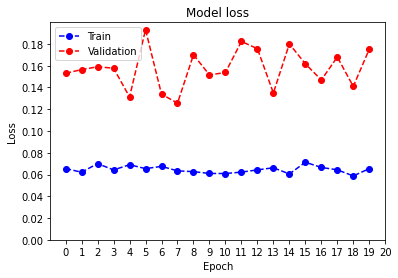

In [65]:
# plot training history
loss_array_all = loss_array4
val_loss_array_all = val_loss_array4

plt.plot(loss_array_all,'bo--')
plt.plot(val_loss_array_all,'ro--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.xticks(np.arange(0,21,1))
plt.yticks(np.arange(0,0.2,0.02))
plt.show()

In [66]:
# looks like this did not help to improve accuracy

In [67]:
# load previous model

import_path_keras='/content/drive/MyDrive/models/siamese_kaggle/1606594514.h5'

model = tf.keras.models.load_model(import_path_keras)
model.summary()




Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         23587712    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2048)         0           sequential[0][0]      

In [68]:
#accuracy on test dataset

tic=time.time()

test_accuracy(X_test,y_test,X_train,y_train)


toc=time.time()    
print(str(toc-tic)+ ' s')

step: 10 accuracy: 63.63636363636363
step: 20 accuracy: 52.38095238095238
step: 30 accuracy: 54.83870967741935
step: 40 accuracy: 53.65853658536585
step: 50 accuracy: 52.94117647058823
step: 60 accuracy: 54.09836065573771
step: 70 accuracy: 50.70422535211268
step: 80 accuracy: 51.851851851851855
step: 90 accuracy: 47.252747252747255
step: 100 accuracy: 44.554455445544555
step: 110 accuracy: 43.24324324324324
step: 120 accuracy: 42.97520661157025
step: 130 accuracy: 43.51145038167939
step: 140 accuracy: 42.5531914893617
step: 150 accuracy: 43.04635761589404
step: 160 accuracy: 43.47826086956522
step: 170 accuracy: 44.44444444444444
step: 180 accuracy: 44.19889502762431
step: 190 accuracy: 45.54973821989529
step: 200 accuracy: 44.776119402985074
step: 210 accuracy: 44.07582938388626
step: 220 accuracy: 44.34389140271493
step: 230 accuracy: 44.58874458874459
step: 240 accuracy: 44.398340248962654
step: 250 accuracy: 44.62151394422311
step: 260 accuracy: 44.44444444444444
step: 270 accurac

In [69]:
# accuracy slightly improved (from 38 %) since last 50 epochs, let's check if we can train even further

In [70]:
# switch zoom back on in data augmentation


# Data augmentation

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=180,
            zoom_range=0.5,
            height_shift_range=0.1,
            width_shift_range=0.1,
           #brightness_range=[0.2,1]
            )


In [ ]:
# keep training

tic=time.time()


trained5 = model.fit(
            pairs_generator(batch_size),
            steps_per_epoch=steps_per_epoch,
            validation_data = pairs_generator(batch_size,valid=True),
            validation_steps = validation_steps,
            epochs=50,
            callbacks=[cp_callback]
            )


toc=time.time()    
print(str(toc-tic)+ ' s')





Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.0830
Epoch 00001: val_loss did not improve from 0.12559
200/200 [==============================] - 209s 1s/step - loss: 0.0830 - val_loss: 0.1710
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.0813
Epoch 00002: val_loss did not improve from 0.12559
200/200 [==============================] - 199s 993ms/step - loss: 0.0813 - val_loss: 0.1522
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.0810
Epoch 00003: val_loss did not improve from 0.12559
200/200 [==============================] - 198s 991ms/step - loss: 0.0810 - val_loss: 0.1960
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.0879
Epoch 00004: val_loss did not improve from 0.12559
200/200 [==============================] - 202s 1s/step - loss: 0.0879 - val_loss: 0.1833
Epoch 5/50
200/200 [==============================] - ETA: 0s - loss: 0.0844
Epoch 00005: val_loss did not improve from 0.

In [ ]:
# load best weights
checkpoint_filepath = "/content/drive/MyDrive/models/siamese_kaggle/cp.ckpt"
model.load_weights(checkpoint_filepath)